# Blacklist Triage Analysis

This notebook analyzes the results of a two-stage blacklisting procedure to diagnose why some data points from the ATC0 dataset are causing infinite loss and infinite gradients that corrupt the neural net weights. The two stages isolate individually-problematic data points vs problematic sequences of data points. 

In both stages, we set the batch size to one data point (one utterance) and log whether the batch produced finite or infinite gradients. In stage 1, we iterate through all the data points, training a fresh model on a single batch. In stage 2, iteratively a) filter out blacklisted data points b) train a fresh model on as many batches as possible until the next corrupted gradient is detected.

Stage 1 failed to produce any infinite gradients in 478 batches: this strongly suggests that utterances are not individually problematic. The rest of the notebook explores whether the length or ordering of batches matters.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

*To run this notebook, move this notebook to the asr/models/speechbrain folder!*

## "Good" Sequence Lengths

In this section we'll measure the distribution over the number of batches the model successfully trains before it encounters an infinite gradient. 

In [2]:
# Compute the trial index ie number of elements in blaclist at time of test
blist = pd.read_csv('ctc/hparams/blacklist.csv')
blist_len = []
counter = 0
for elem in blist['is_finite']:
    blist_len.append(counter)
    if not elem:
        counter += 1
blist = blist.assign(trial=blist_len, sequence_len = blist['batch']+1)

In [3]:
# Get failure list
fails = blist.loc[(blist['pass'] == 'second') & (blist['is_finite'] == False)]

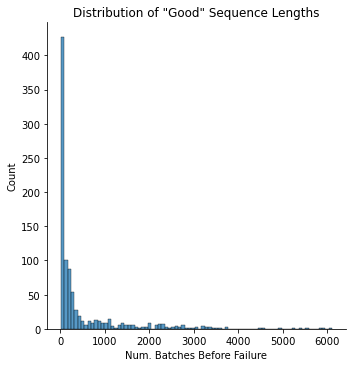

In [4]:
# Plot distribution of sequence lenghts
g = sns.displot(data=fails, x='sequence_len')
g.set(xlabel="Num. Batches Before Failure", ylabel="Count",
    title='Distribution of "Good" Sequence Lengths');

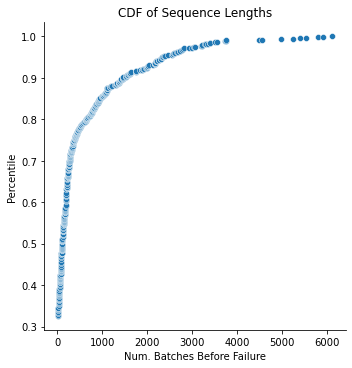

In [5]:
plot_data = fails[['batch']].value_counts().reset_index()
plot_data.columns = ['batch', 'count']
plot_data = plot_data.sort_values(by='batch').assign(
    pct=lambda x: x['count'].cumsum() / x['count'].sum())
g = sns.relplot(data=plot_data, x='batch', y='pct')
g.set(xlabel="Num. Batches Before Failure", ylabel="Percentile", title="CDF of Sequence Lengths");

**Takeaways**

Half of the failures occur on the 11th batch. None occur before that. 

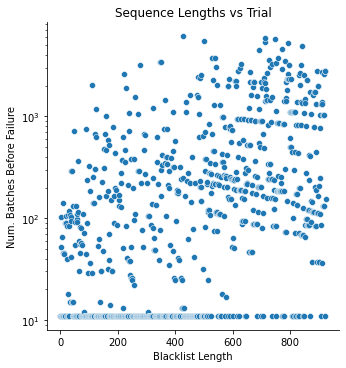

In [6]:
# Plot sequence lengths vs trial (do they get better over time?)
g = sns.relplot(data=fails, x='trial', y='sequence_len')
g.set(yscale='log', xlabel="Blacklist Length", ylabel="Num. Batches Before Failure", 
    title='Sequence Lengths vs Trial');

**Takeaways**

The failures at batch 11 occur consistently across trials.

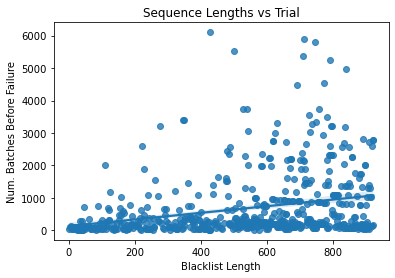

In [7]:
# Plot sequence lengths vs trial (do they get better over time?)
g = sns.regplot(data=fails.loc[fails['sequence_len'] > 11], x='trial', y='sequence_len')
g.set(xlabel="Blacklist Length", ylabel="Num. Batches Before Failure",
    title="Sequence Lengths vs Trial");

**Takeaways**

Exclusing the batch 11 failures, the sequences do get better over time, so there is a chance there's a strict subset of bad data points.

## CTC Constraints

In [8]:
from bpc_prepare import prepare_bpc

In [9]:
# Get the original ATC0 data as used by the model
import os
os.makedirs('tmp', exist_ok=True)
prepare_bpc('rcc', 'atczero', None, None, {'train': .8, 'val': .1, 'test': .1}, 'tmp')

In [10]:
# Read in the dataset and join together the splits
data = pd.concat([pd.read_csv('tmp/train.csv').assign(split='train'),
                pd.read_csv('tmp/val.csv').assign(split='val'),
                pd.read_csv('tmp/test.csv').assign(split='test')],
                ignore_index=True)

In [11]:
# Compute some helpful extra columns on the data
SAMPLE_RATE = 8000  # Hz
root='/project/graziul/ra/wdolan/atc0_comp/atc0_'
data = data.assign(
    airport=data['wav'].str.replace(root,'').str.slice(0,3),
    frames=SAMPLE_RATE * data['duration'],
    charlen=data['transcript'].str.len()
)

In [12]:
# Check the CTC constraint the X > Y
plot_data = fails.merge(data, on='ID').assign(
    xlty=lambda x: x['frames'] < x['charlen'])

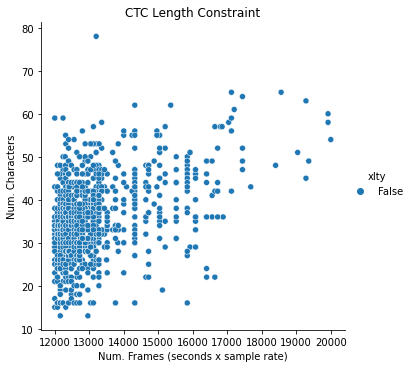

In [13]:
g = sns.relplot(data=plot_data, x='frames', y='charlen', hue='xlty')
g.set(ylabel="Num. Characters", xlabel="Num. Frames (seconds x sample rate)", title="CTC Length Constraint");

**Takeaways**
The data points do not fail the CTC length constraint. The input is not shorter than the output.

In [14]:
# Split the data into failed/not-failed/not-tested and look for patterns
SAMPLE_RATE = 8000  # Hz
goods = blist.loc[(blist['pass'] == 'second') & (blist['is_finite']), 'ID']
bads = blist.loc[(blist['pass'] == 'second') & (~blist['is_finite']), 'ID']
only_good = blist.loc[~blist['ID'].isin(bads), 'ID']
only_bad = blist.loc[~blist['ID'].isin(goods), 'ID']
good_bad = blist.loc[(blist['ID'].isin(goods)) & 
                      (blist['ID'].isin(bads)), 'ID']
batch11 = blist.loc[blist['batch'] == 10, 'ID']
plot_data = data.assign(
    xlty=lambda x: x['frames'] < x['charlen'],
    batch11= lambda x: x['ID'].isin(batch11),
    only_good= lambda x: x['ID'].isin(only_good),
    only_bad= lambda x: x['ID'].isin(only_bad),
    good_bad= lambda x: x['ID'].isin(good_bad),
    outcome= '?')
plot_data.loc[plot_data['only_good'], 'outcome'] = 'good'
plot_data.loc[plot_data['only_bad'], 'outcome'] = 'bad'
plot_data.loc[plot_data['good_bad'], 'outcome'] = 'good/bad'

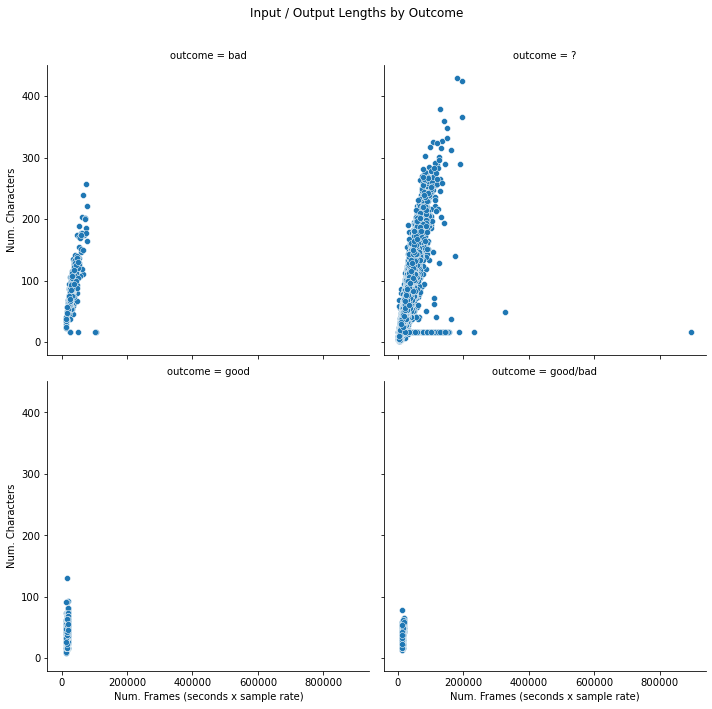

In [15]:
g = sns.relplot(data=plot_data, x='frames', y='charlen', 
    col='outcome', col_wrap=2)
g.set(ylabel="Num. Characters", xlabel="Num. Frames (seconds x sample rate)")
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle("Input / Output Lengths by Outcome");

**Takeaways**

The known outcomes are all shorter because training is ordered by length. We haven't run the second blacklisting pass enough times to see the top end of the length distribution.

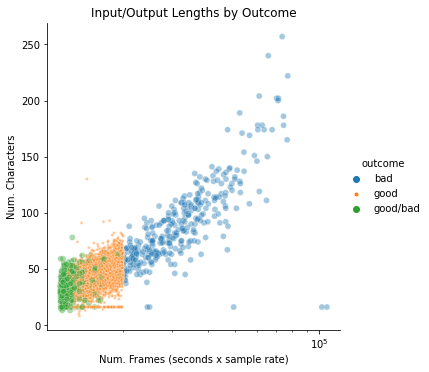

In [16]:
# g = sns.relplot(data=plot_data.loc[plot_data['outcome'] != '?'], 
#                 x='frames', y='charlen', col='outcome', 
#                 col_wrap=2,
#                 alpha=.4,
#                 style='outcome', markers=markers)
markers = {'good': '.', 'bad': 'o', 'good/bad': 'o'}
g = sns.relplot(data=plot_data.loc[plot_data['outcome'] != '?'], 
                x='frames', y='charlen', hue='outcome', alpha=.4,
                style='outcome', markers=markers)
g.set(ylabel="Num. Characters", xlabel="Num. Frames (seconds x sample rate)", title="Input/Output Lengths by Outcome",
    xscale='log');

**Takeaways**

The always-bad points are categorially longer inputs. The sometimes-bad points are categorically shorter inputs. 

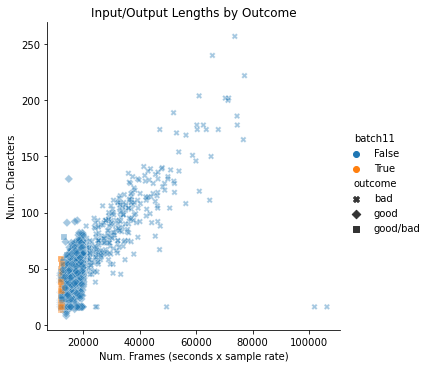

In [17]:
# g = sns.relplot(data=plot_data.loc[plot_data['outcome'] != '?'], 
#                 x='frames', y='charlen', col='outcome', 
#                 col_wrap=2,
#                 alpha=.4,
#                 style='outcome', markers=markers)
markers = {'good': 'D', 'bad': 'X', 'good/bad': 's'}
g = sns.relplot(data=plot_data.loc[plot_data['outcome'] != '?'], 
                x='frames', y='charlen', hue='batch11', alpha=.4,
                style='outcome', markers=markers)
g.set(ylabel="Num. Characters", xlabel="Num. Frames (seconds x sample rate)", title="Input/Output Lengths by Outcome");

In [18]:
plot_data.loc[plot_data['batch11'] & (~(plot_data['outcome'] == 'good/bad'))].shape

(2, 14)

**Takeaways**

All of batch 11 (except for one) are in the good/bad group. This is sort of expected and sort of not, after we've noticed the outcomes are stratified by duration.

## Batch 11

In [19]:
pre11 = blist.loc[(blist['pass'] == 'second') & (blist['batch'] < 10)]
pre11_unique = pre11['ID'].unique()
pre11_strings = ','.join([str(x) for x in pre11_unique])
print(f"Unique data point ids in batches 1-10: {pre11_strings}")

Unique data point ids in batches 1-10: 1270,23536,5493,15404,19209,15912,20770,27422,8612,1843


In [20]:
print(f"Do any data points in batches 1-10 fail in other trials? {pre11['ID'].isin(bads).unique()}")

Do any data points in batches 1-10 fail in other trials? [False]


In [21]:
print("Table of first 10 batches:")
pre11.merge(data, on='ID')[['ID','duration','airport', 'wrd']].drop_duplicates()

Table of first 10 batches:


,ID,duration,airport,wrd
0,1270,1.5,bos,TWO TEN DELTA SIX FORTY EIGHT
934,23536,1.5,dfw,SAY AGAIN THE FREQ FOR DELTA THREE TWO SEVEN
1868,5493,1.5,bos,EIGHTEEN TWENTY FIVE
2802,15404,1.5,dca,EAGLE ONE GO AHEAD
3736,19209,1.5,dfw,AMERICAN TWELVE SEVENTY FOUR IS IN A TURN
4670,15912,1.5,dca,OKAY WE'LL MONITOR BYE
5604,20770,1.5,dfw,DELTA FIVE TWENTY TWO HEADING ZERO FOUR ZERO
6538,27422,1.5,dfw,OK WE'LL DO THAT
7472,8612,1.5,dca,PACER EIGHT ONE OUT OF THREE FOR FOUR THOUSAND
8406,1843,1.5,bos,AH DOUBLE OH EIGHT U S EIGHT FIFTY TWO


**Takeaways**

The 'good' data points before the 11th batch are always the same. They never failed.

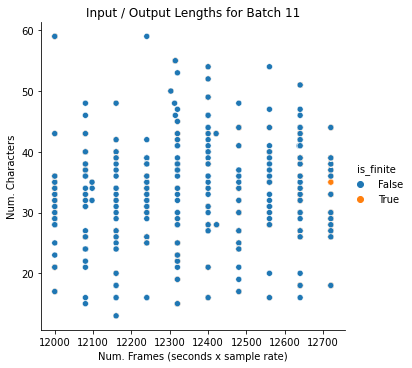

In [22]:
plot_data = blist.loc[blist['batch'] == 10] \
            .merge(data, on='ID')
g = sns.relplot(data=plot_data,
                x='frames', y='charlen', hue='is_finite')
g.set(ylabel="Num. Characters", xlabel="Num. Frames (seconds x sample rate)", title="Input / Output Lengths for Batch 11");

**Takeaways**

Since the training order is fixed, there is only one 'good' 11th data point. Though the bad ones tend to be shorter. 

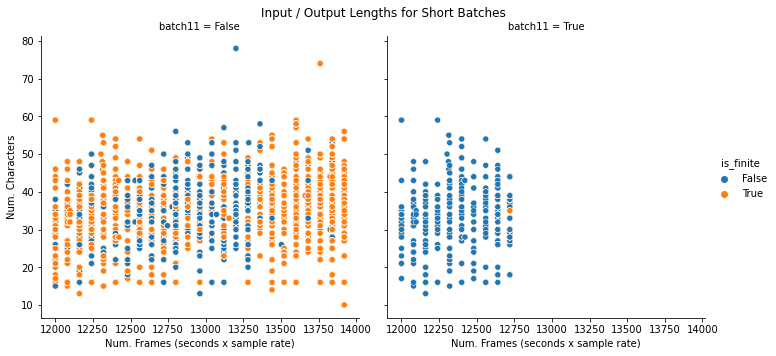

In [24]:
plot_data = blist.merge(data, on='ID')
plot_data = plot_data.loc[plot_data['frames'] < 14000]
plot_data = plot_data.assign(batch11 = plot_data['batch'] == 10)
g = sns.relplot(data=plot_data,
                x='frames', y='charlen', hue='is_finite',
                col='batch11')
g.set(ylabel="Num. Characters", xlabel="Num. Frames (seconds x sample rate)", )
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Input / Output Lengths for Short Batches");